In [101]:
# Importing necessary libraries
import torch
import pandas as pd
import numpy as np
import spacy
from sentence_transformers import util
from sentence_transformers import util
from sentence_transformers import SentenceTransformer


model = SentenceTransformer('all-MiniLM-L6-v2' ,device="cuda")
# ** Use any model of your liking for creating word embedding, The versatile SentenceTransformer model provided by sbert is adept at generating word embeddings, capable of capturing semantic representations for both isolated words and complete sentences.
# ** For utlizing spaCy embeddings use :
"""
    embedding = nlp(word).vector

"""
# ** For utlizing gensim Word2Vec embedding use :

"""
    # (Recommended Gensim version ; 3.8.2)
    import gensim.downloader as api
    model = api.load("glove-wiki-gigaword-200)
    if word in self._model.index_to_key:
        embedding = self._model[word]

"""

nlp = spacy.load("en_core_web_md")

TargetSet1 = ["sports", "football", "athletics", "game"]
TargetSet2   = ["crime", "murder", "theft", "violence"] 

ts1emb = model.encode(TargetSet1)
ts2emb = model.encode(TargetSet2)

ts1emb = torch.tensor(np.mean(ts1emb, axis = 0), device= "cuda")
ts2emb = torch.tensor(np.mean(ts2emb, axis = 0), device= "cuda")

In [100]:
# data = pd.read_csv("data/McReview.csv", encoding="latin-1")
# data

data = pd.read_csv("data/articles1.csv")
data = data.sample(n = 5_000)
data.rename(columns={"title" : "text"}, inplace=True)
data = data[["text"]]
data.index = np.arange(len(data))
data['text'] = data['text'].replace(regex='(@\w+)|#|&|!',value='')
data['text'] = data['text'].replace(regex=r'http\S+', value='')

data

,text
0,From divorces and robberies to the stars we lo...
1,"Poll: Paul Ryan Loses to Hillary Clinton, Bern..."
2,"Police Commissioner Bans Gay Sauna, ’Too Close..."
3,Shia LaBeouf begins four-year Trump protest
4,Germany ax attack: Seven injured at train station
...,...
4995,’Battlefield 1’ - ’They Shall Not Pass’ Traile...
4996,"Berlin, Russia, Narendra Modi: Your Morning Br..."
4997,Here are some of the most bizarre things fligh...
4998,Huffington Post Won’t Drop Article Claiming Je...


In [102]:
from tqdm import tqdm, trange

def calculate_word_biases(data, text_column):
    wbias = []
    w_emb = {}
    embeds = {}

    for i in trange(len(data)):
        sent = data[text_column].iloc[i]
        try:
            doc = nlp(str(sent))
        except Exception as e:
            print(e)
            print(i)
            continue

        bias_list = []
        for token in doc:
            if token.pos_ == "ADJ" or token.pos_ == "PRON" or token.pos_ == "NOUN":
                word = token.text_with_ws.strip().lower()
                if word in w_emb:
                    bias_list.append(w_emb[word])
                    continue
                wv = torch.tensor(model.encode(word), device="cuda")
                a = util.cos_sim(ts1emb, wv)
                b = util.cos_sim(ts2emb, wv)

                bias = (a - b).item()
                embeds[word] = wv
                bias_list.append(bias)

                w_emb[word] = bias
        wbias.append(np.array(bias_list))

    biased_words = list(w_emb.items())
    biased_words.sort(key=lambda x: x[1])

    return (wbias, embeds, biased_words)


wbias, embeds, biased_words = calculate_word_biases(data, "text")


100%|██████████| 5000/5000 [01:17<00:00, 64.61it/s] 


In [103]:
biased_words[-10:]

[('footballers', 0.3216857314109802),
 ('ball', 0.3528217077255249),
 ('olympic', 0.360790491104126),
 ('basketball', 0.3614656627178192),
 ('soccer', 0.41569265723228455),
 ('athletes', 0.4307401776313782),
 ('football', 0.44955843687057495),
 ('sport', 0.46948710083961487),
 ('sports', 0.5270998477935791),
 ('sporting', 0.5295244455337524)]

In [104]:
biased_words[:10]

[('crime', -0.4632261097431183),
 ('crimes', -0.46259060502052307),
 ('murders', -0.45060572028160095),
 ('murder', -0.44723308086395264),
 ('criminals', -0.42452579736709595),
 ('homicides', -0.3801370859146118),
 ('robberies', -0.37821757793426514),
 ('arrest', -0.37457209825515747),
 ('violence', -0.36726266145706177),
 ('robber', -0.35509389638900757)]

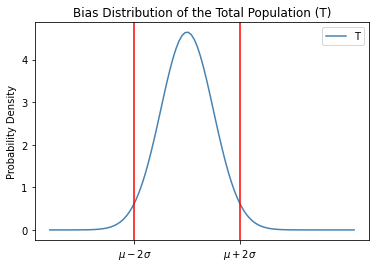

In [105]:
import numpy as np

# Sort the data in ascending order
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

total_pop = [b for _, b in biased_words]
x = np.linspace(np.min(total_pop), np.max(total_pop), 100)

# Calculate the probability density function (PDF) of the total_pop
mu = np.mean(total_pop)
sigma = np.std(total_pop)

pdf = norm.pdf(x, mu, sigma)

# Plot the curve
plt.plot(x, pdf, color='steelblue', label='T')
plt.axvline(x=mu - 2 * sigma, color = "red")
plt.axvline(x=mu + 2 * sigma, color = "red")

plt.title('Bias Distribution of the Total Population (T)')
# plt.xlabel('Values')
plt.ylabel('Probability Density')
plt.xticks([mu - 2 * sigma, mu + 2 * sigma],[r"$\mu - 2\sigma$", r"$\mu + 2\sigma$"])
# Add a legend
plt.legend()

# Display the plot
plt.show()


In [106]:
mu-2*sigma, mu+2*sigma

(-0.18728631448990624, 0.15604529049735616)

In [107]:
import numpy as np


# Sort the data in ascending order
total_pop = [b for _, b in biased_words]
sorted_data = np.sort(total_pop)
# Calculate the quantiles for the three segments
quantiles = np.quantile(sorted_data, [0.07, 0.93])
# Divide the data based on the quantile thresholds
U2 = sorted_data[sorted_data <= quantiles[0]]
Un = sorted_data[(sorted_data > quantiles[0]) & (sorted_data < quantiles[1])]
U1 = sorted_data[sorted_data > quantiles[1]]
U2.mean(), U1.mean()

(-0.20775994726202704, 0.14714973199773917)

In [108]:
class1 = []
class2 = []
classn = []

for ind in trange(len(data)):
    sample = wbias[ind]

    likelihood1 = np.sum((norm.logpdf(sample, np.mean(U1), np.std(U1))))
    likelihood2 = np.sum((norm.logpdf(sample, np.mean(U2), np.std(U2))))
    likelihood3 = np.sum((norm.logpdf(sample, np.mean(Un), np.std(Un))))

    # Compare likelihoods
    likelihoods = [likelihood1, likelihood2, likelihood3]
    population_labels = ['Population 0', 'Population 1', 'Population 2']
    best_fit_population = np.argmax(likelihoods)

    if abs(max(likelihoods)) < 0:
        classn.append((ind, max(likelihoods)))
        continue

    if best_fit_population == 2:
        classn.append((ind, max(likelihoods)))
    elif best_fit_population == 0 and max(likelihoods) :
        class1.append((ind, max(likelihoods)))
    else:
        class2.append((ind, max(likelihoods)))

100%|██████████| 5000/5000 [00:02<00:00, 2310.59it/s]


In [109]:
for s in data[data.index.isin([i for i, _ in class1])].text:
    print(s)

Ben Carson on Meeting with Ted Cruz: ’I’m Ready to Move on’ - Breitbart
College Costs Too Much? N.Y.U. Paves Way to Graduate Faster - The New York Times
’Climate change’ banned for Florida officials
Lindsey Vonn romps to speed double at World Cup finals
Boko Haram Video Shows Corpses of Chibok Girls ’Killed by Airstrikes’ - Breitbart
Narendra Modi Bolsters India’s Ties With U.S., Thanks (Partly) to Donald Trump - The New York Times
The Nuclear Option: As the World Burns, ’Clinton News Network’ Sets Out to Prove Trump Is Crazy - Breitbart
Booming Crowds at Ted Cruz Illinois Stops Continue Day Before Super Second Tuesday - Breitbart
Barbra Streisand Blasts ’Outright Sexism’ in Media’s Coverage of Hillary Clinton - Breitbart
Linda Tripp: Hillary Threw Hard Objects at Bill Clinton
NFL star sits in protest during national anthem
G7 Fashion: First Lady Melania Trump Outshines Fellow NATO Spouses In Blossoming Ensemble
Soccer player Oliver Minatel attacked on plane
Russia will deploy a divisi

In [111]:
for s in data[data.index.isin([i for i, _ in class2])].text:
    print(s)

Paul Ryan: ’No Evidence’ of Sessions Colluding with Russia During Election - Breitbart
CBO Releases Score of Paul Ryan’s American Health Care Act - Breitbart
How to Hide $400 Million - The New York Times
’Si’: In Puerto Rico, Bernie Sanders Vows To Legalize Marijuana - Breitbart
Alix Tichelman sentenced in Google executive’s death
First Look: Woody Allen-Miley Cyrus Amazon Series ’Crisis in Six Scenes’ - Breitbart
Kanye West Begs Mark Zuckerberg for $1 Billion - Breitbart
Comedian Sacha Baron Cohen Suggests Trump will Choose Bill Cosby for V.P. - Breitbart
Flooding Compounds Pain of Tragic Summer in Baton Rouge - The New York Times
Democrats, advocates question ICE enforcement raids
NY Post: Why Didn’t the Democrats Even Mention the Clinton Foundation? - Breitbart
Paul Ryan Backs President Obama’s Sanctions Over Alleged Russian Hacks - Breitbart
BookCourt, a Literary Cornerstone in Brooklyn, Is Closing - The New York Times
White Flight: Young Professionals Flock To Conservative, Mass M